In [1]:
import numpy as np
import pickle
from multiprocessing import Pool, cpu_count

In [2]:
import time
def timer(func):
    def f(*args, **kwargs):
        start = time.time()
        rv = func(*args, **kwargs)
        duration = time.time() - start
        print("Function '{}' finished after {:.4f} seconds."\
              .format(func.__name__, duration))
        return rv
    return f

In [3]:
class Queue(object):
    def __init__(self):
        self.queue = []
         
    def __call__(self):
        return self.queue
  
    def __len__(self):
        return len(self.queue)
    
    def enqueue(self, item):
        self.queue.append(item)
        
    def dequeue(self):
        return self.queue.pop(0)

    def is_not_empty(self):
        return bool(self.queue)

class Node:
    def __init__(self, state, parent=None):
        self.state = state
        self.parent = parent
        if self.parent:
            self.depth = parent.depth + 1
        else:
            self.depth = 0

In [4]:
class ShelfSolver:
    def __init__(self, shelf_size=(5,5), n_shapes=4, n_colors=4, random_seed=None):
        self.shelf_size = shelf_size
        self.n_shapes = n_shapes
        self.n_colors = n_colors
        self.random_seed = random_seed
    
    def new_random_shelf(self, seeded=False):
        ''' Return a new random shelf matrix '''
        # Create indices
        if seeded: np.random.seed(self.random_seed)
        indices = np.random.choice(
            self.shelf_size[0]*self.shelf_size[1], 
            size = self.n_shapes*self.n_colors,
            replace=False)
        # Create empty shelf
        shelf = np.zeros(self.shelf_size[0]*self.shelf_size[1])
        # Create objects
        objects = np.array([i+j for j in np.arange(10,(self.n_colors+1)*10,10) \
                   for i in np.arange(1,self.n_shapes+1,1)])
        # Populate shelf with objects and reshape
        shelf[indices] = objects
        shelf = shelf.reshape(self.shelf_size)
        shelf = np.asarray(shelf, dtype=int)
        #shelf = np.asarray(shelf, dtype=str)
        return shelf
    
    def assign_bases(self, shelf):
        base_ids = dict()
        for row_id, row in enumerate(shelf):
            color_counts = self.count_colors_in_row(row)
            colors_with_highest_count = np.argwhere(
                color_counts == np.max(color_counts))
            if colors_with_highest_count.shape[0] == 1:
                if colors_with_highest_count[0,0]+1 in base_ids.values(): 
                    base_ids[row_id] = None # if color already has base set None
                else:
                    base_ids[row_id] = colors_with_highest_count[0,0]+1
            elif colors_with_highest_count.shape[0] > 1:
                base_ids[row_id] = None
                
        # For the leftover colors assign them randomly
        leftover_row_ids = np.argwhere(np.array(list(base_ids.values()))==None)
        leftover_row_ids = [ri[0] for ri in leftover_row_ids] 
        leftover_colors = [color for color in range(1, self.n_colors+1) if color not in list(base_ids.values())]
        assign_ids = np.random.choice(a=leftover_row_ids, size=len(leftover_colors), replace=False)
        for i in range(len(leftover_colors)):
            base_ids[assign_ids[i]] = leftover_colors[i]
    
        return base_ids
    
    def count_colors_in_row(self, row):
        colors_instances = np.zeros(self.n_colors)
        for ob in row:
            if ob != 0:
                color = self.get_color(ob)
                colors_instances[color-1] += 1
        return colors_instances
 
    def is_in_correct_base(self, item, base_ids, row_idx):
        return (base_ids[row_idx] == self.get_color(item))
    
    def move_object(self, shelf, obj, old_position, new_position):
        new_shelf = shelf.copy()
        new_shelf[old_position] = 0
        new_shelf[new_position] = obj
        return new_shelf
    
    def is_final_state(self, base_ids, shelf_state):
        is_final_state = np.ones(shelf_state.shape, dtype=bool)
        for row_idx, row in enumerate(shelf_state):
            for col_idx, item in enumerate(row):
                if item != 0:
                    is_final_state[row_idx,col_idx] = \
                       self.is_in_correct_base(item, base_ids, row_idx)
                else:
                    continue
        return is_final_state.all() # all must be True
    
    def has_been_visited(self, shelf_state, visited_states):
        return hash(str(shelf_state)) in visited_states
    
    @timer
    def solve(self, shelf, base_ids, verbose=0):
        
        # Measure elapsed time
        _start = time.time()
        
        # Enqueue start state
        root_node = Node(shelf)
        queue = Queue()
        queue.enqueue(root_node)
        
        # Collect depths of all correct children
        final_states = []
        collected_depths = []
        
        # Keep track of visited states
        visited_states = []
        
        # Iterate through queue
        while queue.is_not_empty():
            
            node = queue.dequeue()
            if self.is_final_state(base_ids, node.state):
                final_states.append(node.state)
                collected_depths.append(node.depth)
                continue
                #return final_states, collected_depths
            
            # Create children of node and enqueue them
            # by iterating through items
            for i in range(self.shelf_size[0]): # iterate thru row
                for j in range(self.shelf_size[1]): # iterate thru col
                    
                    item = node.state[i,j]
                    if item == 0: # if empty space
                        continue  # do nothing
                        
                    # If object not in correct base
                    if not self.is_in_correct_base(item, base_ids, i):

                        # Find correct row
                        correct_row = list(base_ids.values())\
                            .index(self.get_color(item))
                        
                        # Find empty spaces in correct row
                        empty_space_ids = np.argwhere(
                            node.state[correct_row]==0)
                        
                        # Enqueue all states that move item into empty
                        # space in correct row
                        for empty_space_id in empty_space_ids:
                            new_state = self.move_object(
                                node.state, item, (i,j), 
                                (correct_row, empty_space_id))
                            if not self.has_been_visited(new_state, visited_states):
                                visited_states.append(hash(str(new_state)))
                                child_node = Node(new_state, parent=node)
                                queue.enqueue(child_node)
                    else:
                        continue
            print("Length of queue: {}\r".format(len(queue)), end="")
            #if time.time()-_start > 20:
            #    print("More than 20 seconds elapsed, terminating with queue length of", len(queue))
            #    break
            if len(queue) >= 20000:
                print("Queued 20k items, terminating.")
                break
        
        return list(np.unique(collected_depths))
            
    def get_color(self, obj):
        return obj//10
    
    def get_shape(self, obj):
        return obj%10

In [43]:
#solver = ShelfSolver(shelf_size=(4,4), n_colors=3, n_shapes=3, random_seed=80)
solver = ShelfSolver(random_seed=8)
shelf = solver.new_random_shelf()
base_ids = solver.assign_bases(shelf)
print(shelf)
print(base_ids)

[[13 12 42 33 24]
 [44 34  0  0  0]
 [ 0 31  0 22 32]
 [ 0 21  0 43 41]
 [11 14 23  0  0]]
{0: 1, 1: 2, 2: 3, 3: 4, 4: None}


In [44]:
collected_depths = solver.solve(shelf, base_ids, verbose=0)

Queued 20k items, terminating.
Function 'solve' finished after 25.7146 seconds.


In [ ]:
# Collect search depths
depths = []
#solver = ShelfSolver()

use_multiprocessing = False

def thread_job(shelf):
    base_ids = solver.assign_bases(shelf)
    results = solver.solve(shelf=shelf, base_ids=base_ids)
    return results

n_tries = 200
#shelves = [solver.new_random_shelf() for _ in range(n_tries)]  

if use_multiprocessing:
    pool = Pool(processes=cpu_count())
    collected_depths = pool.map(thread_job, shelves)
    pool.close()
    
else:
    depths = []
    for i in range(n_tries):
        solver = ShelfSolver()
        shelf = solver.new_random_shelf()
        base_ids = solver.assign_bases(shelf)
        results = solver.solve(shelf, base_ids)
        if results:
            depths.append(results[0])
        with open('collected_depths.pickle', 'wb') as handle:
            pickle.dump(collected_depths, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
import os
depth_files = sorted([entry for entry in os.listdir() if entry.split('.')[-1] == 'pickle'])
depth_files

['depths.pickle', 'depths2.pickle', 'depths3.pickle', 'depths4a.pickle']

In [ ]:
depths = np.array([])
for filename in depth_files:
    with open(filename, 'rb') as handle:
        depths = np.append(depths, np.array(pickle.load(handle)))
depths

In [7]:
with open('depths4a.pickle', 'rb') as handle:
    depths = pickle.load(handle)
print(depths)

[9, 9, 9, 9, 10, 9, 9, 8, 7, 8, 8, 8, 8, 8, 9, 8, 10, 9, 9, 10, 9, 9, 8, 9, 9, 10, 8, 9, 7, 8, 7, 9, 7, 10, 10, 9, 9, 9, 9, 9, 9, 9, 7, 8, 9, 8, 7, 8, 8, 9, 9, 7, 9, 9, 9, 8, 9, 8, 8, 9, 9, 9, 9, 9, 9, 8, 10, 9, 8, 8, 8, 8, 8, 8, 8, 9, 10, 9, 8, 10, 7, 7, 9, 9, 8, 8, 8, 9, 7, 8, 9, 8, 7, 9, 9, 10, 9, 6, 9, 9, 9, 8, 9, 9, 10, 10, 8, 9, 9, 9, 8, 8, 9, 8, 9, 10, 9, 9, 10, 9, 10, 10, 9, 8, 8, 8, 7, 8, 8, 9, 8, 9, 9, 8, 9, 9, 9, 6, 9, 8, 9, 9, 7, 9, 9, 10, 7, 8, 9, 7, 5, 9, 8, 8, 9, 8, 7, 9, 9, 7, 9, 9, 9, 9, 9, 10, 9, 9, 9, 8, 9, 9, 9, 10, 8, 10, 8, 10, 8, 8, 9, 9, 8, 8, 7, 9, 9, 9, 8, 9, 7, 9, 9, 9, 7, 7, 9, 8, 8, 9, 9, 8, 8, 10, 10, 8, 9, 7, 9, 9, 10, 6, 9, 9, 9, 7, 9, 8, 9, 8, 8, 10, 9, 9, 8, 8, 6, 8, 8, 10, 7, 9, 9, 8, 10, 9, 10, 8, 7, 9, 8, 10, 10, 7, 8, 8, 9, 9, 9, 9, 7, 9, 9, 9, 9, 8, 9, 9, 8, 9, 9, 9, 8, 7, 9, 9, 8]


In [ ]:
print("Success ratio:", len(depths)/n_tries)
print(depths)
for d in depths:
    depths_over_several_runs.append(d)

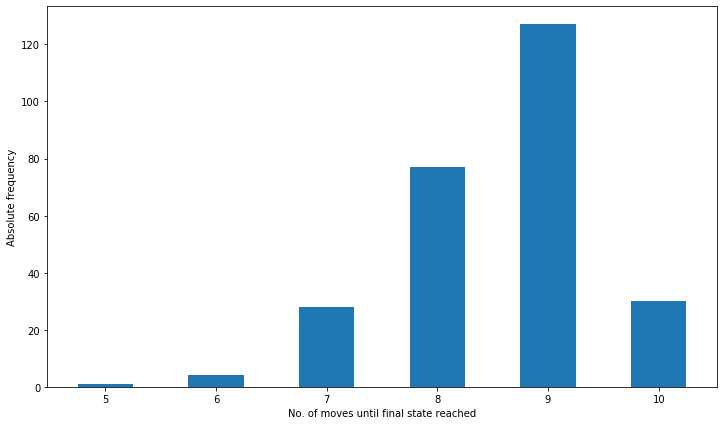

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7))
bins= np.arange(5.,11.,.5) #[5.,5.5,6.,6.5,7.,7.5,8.,8.5,9.,9.5,10.,10.5]
plt.hist(depths, bins,align='left')
#plt.title('Absolute frequencies of number of moves')
plt.xlabel('No. of moves until final state reached')
plt.ylabel('Absolute frequency')
plt.savefig('distribution_of_depths')
plt.show()